# ISYE 6740 Final Project

### Extract the image and organize

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# file: image_organizer
# language: Python 3.9
# purpose: create dataframe that organizes images by patient and then type (normal, virus, bacteria)
#          and then redistributes into more balanced train/test/validate subsets
#          based on patient so that all patient images are in the same subset (train/test/validate)
# NOTES: does not read in or process images, just organizes file handles
#        assumes image files are loaded in subdirectory "chest_xray" under directory with this program

# imports
import numpy as np
import pandas as pd
from random import sample, seed
import matplotlib.image as mpimg
import os
import re

seed(123)

base_dir = "./chest_xray/"
sub_dirs = ["test/NORMAL",
            "test/PNEUMONIA",
            "train/NORMAL",
            "train/PNEUMONIA",
            "val/NORMAL",
            "val/PNEUMONIA"]

image_df = pd.DataFrame(columns=["source_file", "source_dir"], dtype="str")
for sub_dir in sub_dirs:
    source_dir = base_dir + sub_dir
    files = os.listdir(base_dir+sub_dir)
    temp_df = pd.DataFrame(files, columns=["source_file"])
    temp_df["source_dir"] = source_dir
    image_df = pd.concat([image_df, temp_df], ignore_index=True)
image_df = image_df.sort_values(["source_dir", "source_file"])

# set image type: normal, bacterial penumonia or viral pneumonia
types = ["normal", "bacteria", "virus"]
image_df["type"] = "normal"
image_df["type"] = np.where(image_df["source_file"].str.contains("virus"), "virus", image_df["type"])
image_df["type"] = np.where(image_df["source_file"].str.contains("bacteria"), "bacteria", image_df["type"])
for type in types:
    type_df = image_df[image_df.type == type]

# extract patient number from filename
def extract_patient(source_file):
    patient = ""
    if "virus" in source_file:
        patient = str.split(source_file, "_")[0][6:]
    if "bacteria" in source_file:
        patient = str.split(source_file, "_")[0][6:]
    if "NORMAL" in source_file:
        patient = str.split(source_file, "-")[2]
    else:
        if "IM" in source_file:
            patient = str.split(source_file, "-")[1]
    return(int(patient))

image_df["patient"] = image_df["source_file"].apply(extract_patient)
# save copy of intermediate dataframe
image_df.to_csv('./chest_xray/image_df.csv')

# create bucketized dataframe
# where each row represents a patient
# and their are separate columns for images and image counts by type
patients = list(image_df.patient.unique())
xray_data = []
for patient in patients:
    bytype = []
    for type in types:
       subset = image_df[(image_df.patient == patient) & (image_df.type == type)].copy()
       # subset["source"] = subset.source_file
       subset["source"] = subset.source_dir + "/" + subset.source_file
       bytype.append(list(subset["source"]))
    xray_data.append((patient, bytype[0], bytype[1], bytype[2]))
xray_data_df = pd.DataFrame(xray_data, columns=["patient", "normal", "bacteria", "virus"])

# track count of images
def image_count(image_list):
    return len(image_list)
for type in types:
    xray_data_df[type+"_count"] = xray_data_df[type].apply(image_count)
xray_data_df.to_csv('./chest_xray/grouped_image_df.csv')

# partition patients between train, test & validation sets
# note the balancing won't be exact as the number of images of each type vary by patient
# but trials seem to show it provides a reasonable distribution
count = xray_data_df.shape[0]
# proportion of sample for training
train_proportion = 0.6

# shuffle patients
xray_data_df = xray_data_df.sample(frac=1).reset_index(drop=True)

# label sets
xray_data_df["set"] = "train"
train_count = int(count * train_proportion)
test_count = int((count-train_count)/2)
xray_data_df.set[train_count:test_count + train_count] = "test"
# validation set will get whatever is left over ~ approximately same size as test
xray_data_df.set[test_count + train_count:] = "validate"

# display results of oversampling
for set in ["train", "test", "validate"]:
    temp_df = xray_data_df[xray_data_df.set == set]
    print("set", set,
          "normal", np.sum(temp_df.normal_count),
          "bacteria", np.sum(temp_df.bacteria_count),
          "virus", np.sum(temp_df.virus_count))

# export df to files (csv to browse, json to retrieve)
xray_data_df.to_json('./chest_xray/xray_data_df.json')
xray_data_df.to_csv('./chest_xray/xray_data_df.csv')

set train normal 926 bacteria 1654 virus 879
set test normal 339 bacteria 604 virus 318
set validate normal 318 bacteria 522 virus 296


### Resampling the organized images

In [3]:
# file resample_images
# language: Python 3.9
# purpose: resample (oversample) images to correct imbalance between normal, virus & bacteria

# imports
import numpy as np
import pandas as pd
from random import choices, randint, seed
import matplotlib.image as mpimg
import os
import re

seed(123)

# load xray_data_df
xray_data_df = pd.read_json('./chest_xray/xray_data_df.json')

# oversample by set (to prevent contaminating test & validate sets)
# get list of sets & types from data)
sets = ["train", "test", "validate"]
types = ["normal", "bacteria", "virus"]
other_types = ["normal", "virus"]
print(xray_data_df.iloc[0:5])
print("columns", xray_data_df.columns)

for set in sets:
    print("set", set)
    temp_df = xray_data_df[xray_data_df["set"] == set]
    # since bacteria count is always higher than other types
    # we will use bacteria count to oversample other image types
    target_sample = np.sum(temp_df.bacteria_count)

    # oversample normal
    temp2_df = temp_df[temp_df.normal_count > 0]
    patients = list(temp2_df.patient)
    sample = np.sum(temp_df["normal_count"])
    # compute needed sample
    needed_sample = target_sample - sample

    # pull additional samples with replacement
    # samples pulled by patient not by image so as not to overweight patients with multiple images
    # for each sampled patient one normal image is added to the sample
    samples = choices(patients, k=needed_sample)

    # iterate through sample
    for sample in samples:
        images = xray_data_df.normal[xray_data_df["patient"] == sample].iloc[0]
        count = xray_data_df.normal_count[xray_data_df["patient"] == sample].iloc[0]
        if count > 1:
            added_image = images[randint(0, count - 1)]
        else:
            added_image = images[0]
        xray_data_df.normal[xray_data_df.patient == sample].iloc[0].append(added_image)
        xray_data_df.normal_count[xray_data_df.patient == sample] = count + 1

    # oversample virus
    temp2_df = temp_df[temp_df.virus_count > 0]
    patients = list(temp2_df.patient)
    sample = np.sum(temp_df["virus_count"])
    # compute needed sample
    needed_sample = target_sample - sample

    # pull additional samples with replacement
    # samples pulled by patient not by image so as not to overweight patients with multiple images
    # for each sampled patient one normal image is added to the sample
    samples = choices(patients, k=needed_sample)

    # iterate through sample
    for sample in samples:
        images = xray_data_df.virus[xray_data_df["patient"] == sample].iloc[0]
        count = xray_data_df.virus_count[xray_data_df["patient"] == sample].iloc[0]
        if count > 1:
            added_image = images[randint(0, count - 1)]
        else:
            added_image = images[0]
        xray_data_df.virus[xray_data_df.patient == sample].iloc[0].append(added_image)
        xray_data_df.virus_count[xray_data_df.patient == sample] = count + 1


for set in ["train", "test", "validate"]:
    temp_df = xray_data_df[xray_data_df.set == set]
    print("set", set,
          "normal", np.sum(temp_df.normal_count),
          "bacteria", np.sum(temp_df.bacteria_count),
          "virus", np.sum(temp_df.virus_count))

xray_data_df.to_json('./chest_xray/xray_balanced_data_df.json')
xray_data_df.to_csv('./chest_xray/xray_balanced_data_df.csv')


   patient                                             normal  \
0     1872                                                 []   
1      964                                                 []   
2     1685                                                 []   
3      720                                                 []   
4     1329  [./chest_xray/train/NORMAL/NORMAL2-IM-1329-000...   

                                            bacteria  \
0  [./chest_xray/train/PNEUMONIA/person1872_bacte...   
1  [./chest_xray/train/PNEUMONIA/person964_bacter...   
2  [./chest_xray/train/PNEUMONIA/person1685_bacte...   
3  [./chest_xray/train/PNEUMONIA/person720_bacter...   
4  [./chest_xray/train/PNEUMONIA/person1329_bacte...   

                                               virus  normal_count  \
0                                                 []             0   
1  [./chest_xray/train/PNEUMONIA/person964_virus_...             0   
2  [./chest_xray/test/PNEUMONIA/person1685_virus_...          

### PCA Analysis

In [ ]:
"""
Title: Translate Resampled Directories To Data Table
Created on Mon Jul 17 17:53:39 2023
@author: nccru
"""

# %% import packages
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA

# %% extract each image into a new file
def read_path_assignments_to_tuple_list(filepath = './chest_xray/xray_balanced_data_df.csv', image_size = 150):
    """
    Description 
    -------
    Takes the file generated from the resample_images.py file and creates
    a series of three lists of tuples. Each tuple element is a list of 
    [set, patient id, class id, vectorized image].
    
    Inputs
    -------
    `filepath` = Path to the csv file output from the resample_images.py file
    `image_size` = n x n size of the compressed image we want for the sake of
        standardization, as each image may have different baseline dimensions
    
    Returns
    -------
    `train` = list of tuples containing records associated with the training
        data set.
        
    `test` = list of tuples containing records associated with the testing
        data set.
        
    `val` = list of tuples containing records associated with the validation
        data set.
    """
    # read data
    df = pd.read_csv(filepath)
    
    # iterate through each row
    train, test, val = [], [], []
    for i in df.itertuples(index = False):
        # print('--- Patient {} ---'.format(i.patient))
        # extract file paths
        norm_paths = i.normal.strip('[]').split(',')
        bac_paths = i.bacteria.strip('[]').split(',')
        vir_paths = i.virus.strip('[]').split(',')
        
        # read in the images
        def read_image(img_path, img_size = image_size):
            p = re.sub(r"'", '', img_path).strip() # clean up path name
            img_arr = cv2.imread(p, cv2.IMREAD_GRAYSCALE) 
            img_resize = cv2.resize(img_arr, (img_size, img_size)).flatten()
            img_resize_scaled = img_resize / 255
            return img_resize_scaled
        
        def store_image(img_arr, class_id):
            if i.set == 'train':
                train.append((i.set, i.patient, class_id, img_arr))
            elif i.set == 'test':
                test.append((i.set, i.patient, class_id, img_arr))
            else:
                val.append((i.set, i.patient, class_id, img_arr))
            
        ## normal
        for path in norm_paths:
            # print(path)
            if len(path) > 0:
                img = read_image(path)
                store_image(img, 'normal')
        
        ## bacteria
        for path in bac_paths:
            if len(path) > 0:
                img = read_image(path)
                store_image(img, 'bacteria')
                
        ## virus
        for path in vir_paths:
            if len(path) > 0:
                img = read_image(path)
                store_image(img, 'virus')
    
    return train, test, val

# %% convert list of tuples into relevant shapes for plotting
def convert_tuple_list_to_sklearn_objects(train, test, val):
    """
    Description
    -------
    Given a collection of tuple lists [train, test, val], join them all
    together and reshape them meaningfully.
    
    Inputs 
    -------
    `train`, `test`, `val` = Tuple lists from the function 
        read_path_assignments_to_tuple_list
    

    Returns
    -------
    `sets` = An array of defining which set each sample belongs to.
    `y` = The labels for each vectorized image.
    `X` = The vectorized images

    """
    t = train + test + val # stack all lists together
    sets = [set_id for (set_id, patient_id, class_id, arr) in t]
    y = [class_id for (set_id, patient_id, class_id, arr) in t]
    X = np.stack([arr for (set_id, patient_id, class_id, arr) in t])
    
    return sets, y, X

# %% perform PCA on X to reduce dimensionality
def pca_and_convert_to_pandas(X, y, sets, pca_dim = 20):
    """
    Description
    -------
    Given a set of vectorized images `X`, their class labels `y`, and which 
    `sets` they belong to, perform PCA to reduce the dimensionality down to
    `pca_dim`. Then store that as a df.
    
    Note that we have to generate the PCA eigenvalues and eigenvectors on the 
    training data set, then utilize those to transform the test and val sets

    Inputs
    -------
    `X` = The vectorized image array
    `y` = The class the image is associated with
    `sets` = The [train, test, val] assignements
    `pca_dim` = The number of dimensions to reduce to

    Returns
    ------
    `df_pca` = The pandas data frame representation of reduced images.

    """
    # === slice out train test split ===
    
    ## construct pandas dataframe for easier slicing
    df = pd.DataFrame(X)
    df['y'] = y
    df['set'] = sets 

    ## slice out the sets
    X_train = df[df['set'] == 'train'].drop(['y', 'set'], axis = 1).to_numpy()
    y_train = df[df['set'] == 'train']['y'].reset_index(drop = True)
    X_test = df[df['set'] == 'test'].drop(['y', 'set'], axis = 1).to_numpy()
    y_test = df[df['set'] == 'test']['y'].reset_index(drop = True)
    X_val = df[df['set'] == 'validate'].drop(['y', 'set'], axis = 1).to_numpy()
    y_val = df[df['set'] == 'validate']['y'].reset_index(drop = True)

    # === perform PCA  on training component ===
    # === use that to transform test and val ===
    pca = PCA(n_components = pca_dim)
    X_train_pca = pca.fit_transform(X_train)  
    X_test_pca = pca.transform(X_test)
    X_val_pca = pca.transform(X_val)
    
    # === store to pandas dataframe ===
    colnames = ['pca' + str(i) for i in range(pca_dim)]

    ## train
    df_pca_train = pd.DataFrame(X_train_pca, columns = colnames)
    df_pca_train['y'] = y_train
    df_pca_train['set'] = 'train' 

    ## test
    df_pca_test = pd.DataFrame(X_test_pca, columns = colnames)
    df_pca_test['y'] = y_test
    df_pca_test['set'] = 'test' 

    ## val
    df_pca_val = pd.DataFrame(X_val_pca, columns = colnames)
    df_pca_val['y'] = y_val
    df_pca_val['set'] = 'validate' 

    ## merge all together
    df_pca = pd.concat([df_pca_train, df_pca_test, df_pca_val])\
        .reset_index(drop = True)

    return df_pca

# %%
# run through workflow and save to csv
train, test, val = read_path_assignments_to_tuple_list()
sets, y, X = convert_tuple_list_to_sklearn_objects(train, test, val)
final_df = pca_and_convert_to_pandas(X, y, sets)
final_df.to_csv('Pnuemonia Images PCA Reduced.csv')

### Model Development

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import joblib

In [5]:
final_df.replace({'normal':0, 'virus': 1, 'bacteria': 2},inplace=True)

NameError: name 'final_df' is not defined

In [ ]:
X_train = final_df[final_df['set']=='train'].drop(['y', 'set'], axis=1).to_numpy()
X_test  = final_df[final_df['set']=='test'].drop(['y', 'set'], axis=1).to_numpy()
X_val  = final_df[final_df['set']=='validate'].drop(['y', 'set'], axis=1).to_numpy()

In [ ]:
y_train = final_df['y'][final_df['set']=='train'].to_numpy()
y_test = final_df['y'][final_df['set']=='test'].to_numpy()
y_val = final_df['y'][final_df['set']=='validate'].to_numpy()

In [ ]:
#making an instance of each algorithm
knn = KNeighborsClassifier(n_neighbors = 10)
log_reg  = LogisticRegression()
dtc  = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svm = SVC()
xgb = XGBClassifier()

In [ ]:
#fitting each model using X_train and y_train
knn.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

In [ ]:
#scoring each model
print('KNN accuracy score is: ' + str(knn.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm.score(X_test, y_test)))

In [ ]:
xgb_predicted = xgb.predict(X_test)
print('XGBoost accuracy score is: ' + str(accuracy_score(y_test,xgb_predicted)))

In [ ]:
base_scores = {'knn':str(knn.score(X_test, y_test)), 
               'lg':str(log_reg.score(X_test, y_test)), 
               'dt':str(dtc.score(X_test, y_test)), 
               'rf':str(rfc.score(X_test, y_test)), 
               'svm':str(svm.score(X_test, y_test)), 
               'xgb': str(accuracy_score(y_test,xgb_predicted))}

base_scores_df = pd.DataFrame(base_scores, index=[0])
base_scores_df.to_csv("base_acc_scores_df.csv")

In [ ]:
#making predictions for each model
knn_predicted = knn.predict(X_test)
log_reg_predicted = log_reg.predict(X_test)
dtc_predicted = dtc.predict(X_test)
rfc_predicted = rfc.predict(X_test)
svm_predicted = svm.predict(X_test)

In [6]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
    labels = ['Normal', 'virus', 'bacteria']
    cm = confusion_matrix(y_test,predictions)
    cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
    plt.figure(figsize = (7,7))
    plt.title(title)
    sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
    plt.savefig(title+'.png')
    plt.show()

In [ ]:
#plot confusion matrix for each model
plot_cm(knn_predicted, y_test, 'KNN Confusion Matrix (base)')
plot_cm(log_reg_predicted, y_test, 'Logistic Regression Confusion Matrix (base)') 
plot_cm(dtc_predicted, y_test, 'Decision Tree Confusion Matrix (base)')
plot_cm(rfc_predicted, y_test, 'Random Forests Confusion Matrix (base)')
plot_cm(svm_predicted, y_test, 'Support Vector Machine Confusion Matrix (base)')
plot_cm(xgb_predicted, y_test, 'XGBoost Confusion Matrix (base)')

In [7]:
def classification_report_csv(report, title):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dum = lines[6].split('      ')
    row1 = {}
    row1['class'] = dum[0]
    row1['precision'] = ''
    row1['recall'] = ''
    row1['f1_score'] = float(dum[4])
    row1['support'] = float(dum[5])
    report_data.append(row1)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(title+'.csv', index = False)

In [ ]:
#KNN classification report 
report = classification_report(y_test, knn_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'KNN Classification report (base)')
print(report)

In [ ]:
#Logistic Regression classification report 
report = classification_report(y_test, log_reg_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Logistic Regression Classification report (base)')
print(report)

In [ ]:
#Decision Tree classification report 
report = classification_report(y_test, dtc_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Decision Tree Classification report (base)')
print(report)

In [ ]:
#Random Forest classification report 
report = classification_report(y_test, rfc_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Random Forests Classification report (base)')
print(report)

In [ ]:
#SVM classification report 
report = classification_report(y_test, svm_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Support Vector Machine Classification report (base)')
print(report)

In [ ]:
#XGBoost classification report 
report = classification_report(y_test, xgb_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'XGBoost Classification report (base)')
print(report)

#### Hyperparamter tuning

In [ ]:
#knn tunning
knn_ht = KNeighborsClassifier()
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid_knn = GridSearchCV(knn_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_knn=grid_knn.fit(X_train, y_train)

print(grid_search_knn.best_params_)
accuracy = grid_search_knn.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

In [ ]:
best_params_knn = grid_search_knn.best_params_

joblib.dump(grid_search_knn, 'grid_search_knn.joblib')
#loaded_grid_search = joblib.load('grid_search_knn.joblib')

In [ ]:
knn_bm = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'])
knn_bm.fit(X_train, y_train)
y_test_hat=knn_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'KNN Confusion Matrix (bm)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'knn Classification report (bm)')
print(report)

In [ ]:
#logistic regression tunning
log_ht = LogisticRegression()
param_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
 
# defining parameter range
grid_log = GridSearchCV(log_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_log=grid_log.fit(X_train, y_train)

print(grid_search_log.best_params_)
accuracy = grid_search_log.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

In [ ]:
best_params_log = grid_search_log.best_params_

joblib.dump(grid_search_log, 'grid_search_log.joblib')
#loaded_grid_search = joblib.load('grid_search_log.joblib')

In [ ]:
log_bm = LogisticRegression(C= best_params_log['C'], 
                            penalty= best_params_log['penalty'], 
                            solver= best_params_log['solver'])
log_bm.fit(X_train, y_train)
y_test_hat=log_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'Logistic regression Confusion Matrix (bm)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Logistic regression Classification report (bm)')
print(report)

In [ ]:
#Decision Tree tunning
dtc_ht = DecisionTreeClassifier()
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth' : range(1,8),
    'min_samples_split': range(1,8),
    'min_samples_leaf': range(1,5),
}
 
# defining parameter range
grid_dtc = GridSearchCV(dtc_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_dtc=grid_dtc.fit(X_train, y_train)

print(grid_search_dtc.best_params_)
accuracy = grid_search_dtc.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

In [ ]:
best_params_dtc = grid_search_dtc.best_params_

joblib.dump(grid_search_dtc, 'grid_search_dtc.joblib')
#loaded_grid_search = joblib.load('grid_search_dtc.joblib')

In [ ]:
dtc_bm = DecisionTreeClassifier(criterion = best_params_dtc['criterion'], max_depth= best_params_dtc['max_depth'], 
                             min_samples_split= best_params_dtc['min_samples_split'], 
                             min_samples_leaf = best_params_dtc['min_samples_leaf'])
dtc_bm.fit(X_train, y_train)
y_test_hat=dtc_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'Decision Tree Classifier Confusion Matrix (bm)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Decision Tree Classifier Classification report (bm)')
print(report)

In [ ]:
# Random forest tunning
rfc_ht = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': range(1,8),
    'min_samples_split': range(1,8),
    'min_samples_leaf': range(1,5),
}

# defining parameter range
grid_rfc = GridSearchCV(rfc_ht, param_grid, cv=10, scoring='accuracy', return_train_score=True,verbose=1)

# fitting the model for grid search
grid_search_rfc=grid_rfc.fit(X_train, y_train)

print(grid_search_rfc.best_params_)
accuracy = grid_search_rfc.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

In [ ]:
best_params_rfc = grid_search_rfc.best_params_

joblib.dump(grid_search_rfc, 'grid_search_rfc.joblib')
# loaded_grid_search = joblib.load('grid_search_rfc.joblib')

In [ ]:
rfc_bm = RandomForestClassifier(n_estimators = best_params_rfc['n_estimators'], 
                                max_depth= best_params_rfc['max_depth'], 
                                min_samples_split= best_params_rfc['min_samples_split'], 
                                min_samples_leaf = best_params_rfc['min_samples_leaf'])
rfc_bm.fit(X_train, y_train)
y_test_hat=rfc_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'Random Forest Classifier Confusion Matrix (bm)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Random Forest Classifier Classification report (bm)')
print(report)

In [ ]:
#SVM tunning
svm_ht = SVC()
param_grid = { 
    'C':[0.1,100,200],
    'kernel':['rbf','poly'],
    'degree':[2,3,4,5],
    'gamma': [1, 0.1, 0.01]
    }
# defining parameter range
grid_svm = GridSearchCV(svm_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_svm=grid_svm.fit(X_train, y_train)

print(grid_search_svm.best_params_)
accuracy = grid_search_svm.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

In [ ]:
best_params_svm = grid_search_svm.best_params_

joblib.dump(grid_search_svm, 'grid_search_svm.joblib')
#loaded_grid_search = joblib.load('grid_search_svm.joblib')

In [ ]:
svm_bm = SVC(C = best_params_svm['C'], kernel = best_params_svm['kernel'], 
          degree= best_params_svm['degree'], gamma= best_params_svm['gamma'])
svm_bm.fit(X_train, y_train)
y_test_hat=svm_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'SVM Classifier Confusion Matrix (bm)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'SVM Classifier Classification report (bm)')
print(report)

In [ ]:
#XGBoost tunning
xgb_ht = XGBClassifier()
param_grid = {
    'max_depth': range (1, 8),
    'n_estimators': [100, 200, 400],
    'learning_rate': [1, 0.1, 0.05, 0.01]
}
# defining parameter range
grid_xgb = GridSearchCV(xgb_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_xgb=grid_xgb.fit(X_train, y_train)

print(grid_search_xgb.best_params_)
accuracy = grid_search_xgb.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

In [ ]:
best_params_xgb = grid_search_xgb.best_params_

joblib.dump(grid_search_xgb, 'grid_search_xgb.joblib')
#loaded_grid_search = joblib.load('grid_search_xgb.joblib')

In [ ]:
xgb_bm = XGBClassifier(max_depth = best_params_xgb['max_depth'], 
                       n_estimators = best_params_xgb['n_estimators'], 
                       learning_rate = best_params_xgb['learning_rate'])
xgb_bm.fit(X_train, y_train)
y_test_hat=xgb_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'XGBoost Classifier Confusion Matrix (bm)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'XGBoost Classifier Classification report (bm)')
print(report)

### Convolutional Neural Network

In [27]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.random import set_seed
set_seed(123)

In [22]:
# Function to process each row of the dataframe and return a new dataframe
def process_row(row):
    normal = pd.DataFrame({'class': 'normal', 'image_path': row['normal'], 'set': row['set']})
    bacteria = pd.DataFrame({'class': 'bacteria', 'image_path': row['bacteria'], 'set': row['set']})
    virus = pd.DataFrame({'class': 'virus', 'image_path': row['virus'], 'set': row['set']})
    return pd.concat([normal, bacteria, virus], ignore_index=True)

# Apply the function to each row to create a list of dataframes, then concatenate them
df = pd.concat(xray_data_df.apply(process_row, axis=1).tolist(), ignore_index=True)

# Remove rows with empty image_path
df = df[df['image_path'].apply(lambda x: len(x) > 0)]

print(df)

         class                                         image_path       set
0     bacteria  ./chest_xray/train/PNEUMONIA/person1872_bacter...     train
1     bacteria  ./chest_xray/train/PNEUMONIA/person1872_bacter...     train
2     bacteria  ./chest_xray/train/PNEUMONIA/person964_bacteri...     train
3        virus  ./chest_xray/train/PNEUMONIA/person964_virus_1...     train
4        virus  ./chest_xray/train/PNEUMONIA/person964_virus_1...     train
...        ...                                                ...       ...
8335    normal  ./chest_xray/train/NORMAL/NORMAL2-IM-1266-0001...  validate
8336  bacteria  ./chest_xray/train/PNEUMONIA/person1266_bacter...  validate
8337  bacteria  ./chest_xray/train/PNEUMONIA/person1266_bacter...  validate
8338     virus  ./chest_xray/train/PNEUMONIA/person1266_virus_...  validate
8339  bacteria  ./chest_xray/train/PNEUMONIA/person1787_bacter...  validate

[8340 rows x 3 columns]


In [23]:
train_df = df[df['set']=='train'].copy()
train_df.drop(['set'], axis=1, inplace = True)

In [24]:
test_df = df[df['set']=='test'].copy()
test_df.drop(['set'], axis=1, inplace = True)

In [25]:
val_df = df[df['set']=='validate'].copy()
val_df.drop(['set'], axis=1, inplace = True)

In [33]:
# constants
batch_size = 16
image_size = (64, 64)
epochs = 50

# CNN model
model = Sequential([
        keras.Input(shape=(image_size[0], image_size[1], 3)),
        
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(),
        
        keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(),
        
        keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(),
        
        keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(),
        keras.layers.Dropout(0.2),
        
        keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(),
        keras.layers.Dropout(0.2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.7),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Dense(3, activation='softmax')  # Three output nodes for three classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])  # Use categorical cross-entropy as the loss function

# generators to read images from dataset directories
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='class', target_size=image_size, batch_size=batch_size)
validation_generator = train_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='class', target_size=image_size, batch_size=batch_size)
test_generator = test_datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='class', target_size=image_size, batch_size=batch_size)

# callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
# reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
#    callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

Found 4962 validated image filenames belonging to 3 classes.
Found 1566 validated image filenames belonging to 3 classes.
Found 1812 validated image filenames belonging to 3 classes.
Epoch 1/50
311/311 [==============================] - 76s 239ms/step - loss: 1.1514 - accuracy: 0.4976 - val_loss: 1.2651 - val_accuracy: 0.3333
Epoch 2/50
311/311 [==============================] - 80s 257ms/step - loss: 0.7890 - accuracy: 0.6378 - val_loss: 1.5238 - val_accuracy: 0.3333
Epoch 3/50
311/311 [==============================] - 79s 254ms/step - loss: 0.6656 - accuracy: 0.7044 - val_loss: 0.7117 - val_accuracy: 0.6928
Epoch 4/50
311/311 [==============================] - 82s 263ms/step - loss: 0.5940 - accuracy: 0.7505 - val_loss: 1.2371 - val_accuracy: 0.4400
Epoch 5/50
311/311 [==============================] - 87s 281ms/step - loss: 0.5587 - accuracy: 0.7741 - val_loss: 0.7264 - val_accuracy: 0.7152
Epoch 6/50
311/311 [==============================] - 83s 268ms/step - loss: 0.5392 - accura

In [45]:
#test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.n//test_generator.batch_size+1)
y_test_hat = np.argmax(predictions, axis=1)
y_true = test_generator.classes

114/114 [==============================] - 22s 189ms/step


Accuracy for our testing dataset is : 34.82%


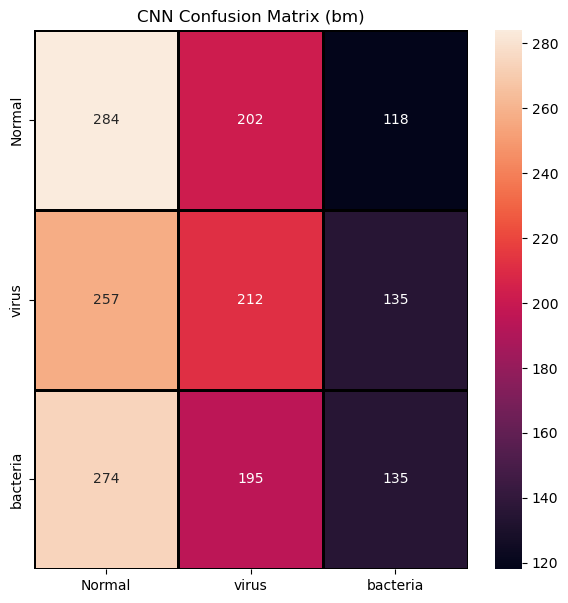

              precision    recall  f1-score   support

  Normal (0)       0.35      0.47      0.40       604
   Virus (1)       0.35      0.35      0.35       604
Bacteria (2)       0.35      0.22      0.27       604

    accuracy                           0.35      1812
   macro avg       0.35      0.35      0.34      1812
weighted avg       0.35      0.35      0.34      1812



In [46]:
test_accuracy=accuracy_score(y_true,y_test_hat )*100
print("Accuracy for our testing dataset is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat , y_true, 'CNN Confusion Matrix (bm)')

report = classification_report(y_true, y_test_hat , target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'CNN Classification report (bm)')
print(report)